In [1]:
# install image classifier 
!pip install -q --upgrade pip
!pip install -q efficientnet

In [2]:
# install relevant packages

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

from tensorflow.keras.mixed_precision import experimental as mixed_precision
from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm

import unicodedata
import re
import numpy as np
import os
import io
import time
import pickle
import math
import random

In [3]:
# seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Detect hardware, set appropriate distribution strategy (GPU/TPU)
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# # set half precision policy
mixed_precision.set_policy('mixed_bfloat16' if TPU else 'float32')

# enable XLA optmizations
tf.config.optimizer.set_jit(True)

print(f'Compute dtype: {mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {mixed_precision.global_policy().variable_dtype}')

Running on TPU  grpc://10.0.0.2:8470
REPLICAS: 8
Compute dtype: bfloat16
Variable dtype: float32


In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("__gcloud_sdk_auth__")

In [6]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [7]:
DEBUG = False # when DEBUG = True, use smaller dataset

# image resolution determined in data cleaning process
IMG_HEIGHT = 256
IMG_WIDTH = 448
N_CHANNELS = 3
# maximum InChI length is 200 to prevent too much padding
MAX_INCHI_LEN = 200

# batch sizes
BATCH_SIZE_BASE = 6 if DEBUG else (64 if TPU else 12) 
BATCH_SIZE = BATCH_SIZE_BASE * REPLICAS
BATCH_SIZE_DEBUG = 2

# target data type, bfloat16 when using TPU to improve throughput
TARGET_DTYPE = tf.bfloat16 if TPU else tf.float32
 # minimal memory usage of labels
LABEL_DTYPE= tf.uint8

# 100K validation images are used
VAL_SIZE = int(100) if DEBUG else int(10000)
VAL_STEPS = VAL_SIZE // BATCH_SIZE

# ImageNet mean and std to normalize training images accordingly
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# Google Cloud Dataset path to training and validation images
GCS_DS_PATH = KaggleDatasets().get_gcs_path('finaldata')

# Tensorflow AUTO flag, used in datasets
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
# character to integer mapping
with open('../input/tokenizer/vocabulary_to_int.pkl', 'rb') as handle:
    vocabulary_to_int = pickle.load( handle)

# integer to character mapping
with open('../input/tokenizer/int_to_vocabulary.pkl', 'rb') as handle:
    int_to_vocabulary = pickle.load( handle)

In [9]:
# configure model
VOCAB_SIZE = len(vocabulary_to_int.values())
SEQ_LEN_OUT = MAX_INCHI_LEN
DECODER_DIM = 1024
ATTENTION_UNITS = 512

print(f'VOCAB_SIZE: {VOCAB_SIZE}')

VOCAB_SIZE: 41


In [10]:
# decodes TFRecord
def decode_tfrecord(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'InChI': tf.io.FixedLenFeature([MAX_INCHI_LEN], tf.int64),
    })

    # decode the PNG and explicitly reshape to image size (required on TPU)
    image = tf.io.decode_png(features['image'])    
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    # normalize according to ImageNet mean and std
    image = tf.cast(image, tf.float32)  / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    
    if TPU: # if running on TPU image needs to be cast to bfloat16
        image = tf.cast(image, TARGET_DTYPE)
    
    InChI = tf.reshape(features['InChI'], [MAX_INCHI_LEN])
    InChI = tf.cast(InChI, LABEL_DTYPE)
    
    return image, InChI

In [11]:
# Benchmark function to test the dataset throughput performance
def benchmark_dataset(dataset, num_epochs=3, n_steps_per_epoch=25, bs=BATCH_SIZE):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_start = time.perf_counter()
        for idx, (images, labels) in enumerate(dataset.take(n_steps_per_epoch)):
            if idx is 1 and epoch_num is 0:
                print(f'image shape: {images.shape}, image dtype: {images.dtype}')
                print(f'labels shape: {labels.shape}, label dtype: {labels.dtype}')
            pass
        epoch_t = time.perf_counter() - epoch_start
        mean_step_t = round(epoch_t / n_steps_per_epoch * 1000, 1)
        n_imgs_per_s = int(1 / (mean_step_t / 1000) * bs)
        print(f'epoch {epoch_num} took: {round(epoch_t, 2)} sec, mean step duration: {mean_step_t}ms, images/s: {n_imgs_per_s}')

In [12]:
# plots the first images of the dataset
def show_batch(dataset, rows=3, cols=2): # for temporary purposes
    imgs, lbls = next(iter(dataset))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*7, rows*4))
    for r in range(rows):
        for c in range(cols):
            img = imgs[r*cols+c].numpy().astype(np.float32)
            img += abs(img.min())
            img /= img.max()
            axes[r, c].imshow(img)

In [13]:
def get_train_dataset(bs=BATCH_SIZE):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/allcleanedimages/train/*.tfrecords')
    train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    train_dataset = train_dataset.with_options(ignore_order)
    train_dataset = train_dataset.prefetch(AUTO) # optimize automatically
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)  # optimize automatically
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
    train_dataset = train_dataset.prefetch(1) # just 1 prefetched batch is needed
    
    return train_dataset

train_dataset = get_train_dataset()

In [14]:
benchmark_dataset(train_dataset)

image shape: (512, 256, 448, 3), image dtype: <dtype: 'bfloat16'>
labels shape: (512, 200), label dtype: <dtype: 'uint8'>
epoch 0 took: 9.45 sec, mean step duration: 378.2ms, images/s: 1353
epoch 1 took: 3.55 sec, mean step duration: 142.1ms, images/s: 3603
epoch 2 took: 1.86 sec, mean step duration: 74.3ms, images/s: 6890


In [15]:
# display statistics about the first image to check if the images are decoded correctly
imgs, lbls = next(iter(train_dataset))
print(f'imgs.shape: {imgs.shape}, lbls.shape: {lbls.shape}')
img0 = imgs[0].numpy().astype(np.float32)
train_batch_info = (img0.mean(), img0.std(), img0.min(), img0.max(), imgs.dtype)
print('train img 0 mean: %.3f, 0 std: %.3f, min: %.3f, max: %.3f, %s' % train_batch_info)

imgs.shape: (512, 256, 448, 3), lbls.shape: (512, 200)
train img 0 mean: -1.881, 0 std: 0.689, min: -2.125, max: 2.641, <dtype: 'bfloat16'>


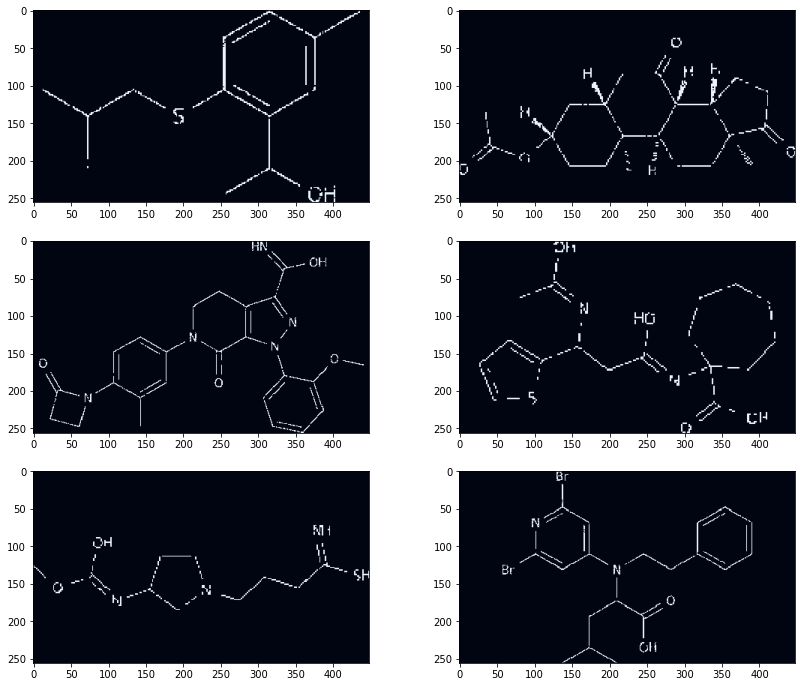

In [16]:
# show first few train images
show_batch(train_dataset)

In [17]:
def get_val_dataset(bs=BATCH_SIZE):
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/allcleanedimages/val/*.tfrecords')
    val_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    val_dataset = val_dataset.prefetch(AUTO)
    val_dataset = val_dataset.repeat()
    val_dataset = val_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    val_dataset = val_dataset.prefetch(1)
    
    return val_dataset

val_dataset = get_val_dataset()

In [18]:
benchmark_dataset(val_dataset)

image shape: (512, 256, 448, 3), image dtype: <dtype: 'bfloat16'>
labels shape: (512, 200), label dtype: <dtype: 'uint8'>
epoch 0 took: 5.26 sec, mean step duration: 210.3ms, images/s: 2434
epoch 1 took: 1.89 sec, mean step duration: 75.5ms, images/s: 6781
epoch 2 took: 1.89 sec, mean step duration: 75.8ms, images/s: 6754


In [19]:
val_imgs, val_lbls = next(iter(val_dataset))
print(f'val_imgs.shape: {val_imgs.shape}, val_lbls.shape: {val_lbls.shape}')
val_img0 = val_imgs[0].numpy().astype(np.float32)
val_batch_info = (val_img0.mean(), val_img0.std(), val_img0.min(), val_img0.max(), val_imgs.dtype)
print('val img 0 mean: %.3f, 0 std: %.3f, min: %.3f, max: %.3f, %s' % train_batch_info)

val_imgs.shape: (512, 256, 448, 3), val_lbls.shape: (512, 200)
val img 0 mean: -1.881, 0 std: 0.689, min: -2.125, max: 2.641, <dtype: 'bfloat16'>


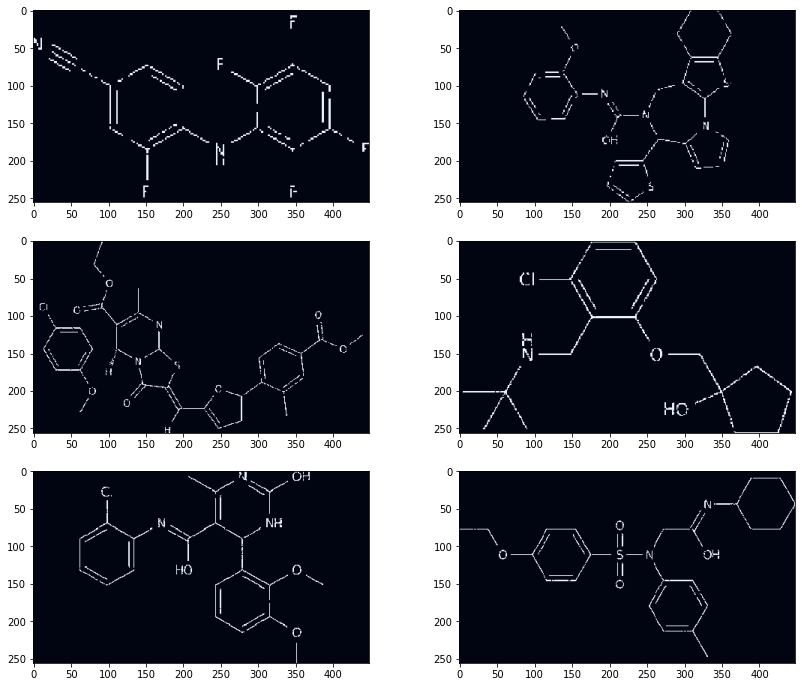

In [20]:
show_batch(val_dataset)

# Model Construction

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # output: (bs, 1280, 14, 8)
        self.feature_maps = efn.EfficientNetB4(include_top=False, weights='noisy-student')
        # set global encoder dimension variable
        global ENCODER_DIM
        ENCODER_DIM = self.feature_maps.layers[-1].output_shape[-1]
        
        # output: (bs, 1280, 112)
        self.reshape = tf.keras.layers.Reshape([-1, ENCODER_DIM], name='reshape_featuere_maps')
        # output: (bs, 112, 1280)
        self.permuate = tf.keras.layers.Permute([2, 1], name='permutate_features_last')

    def call(self, x, training):
        x = self.feature_maps(x, training=training)
        x = self.reshape(x, training=training)
        x = self.permuate(x, training=training)
        return x

In [22]:
with tf.device('/CPU:0'):
    encoder = Encoder()
    encoder_res = encoder(imgs[:BATCH_SIZE_DEBUG])

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(encoder_res.shape))

71680000/71678424 [==============================] - 1s 0us/step
Encoder output shape: (batch size, sequence length, units) (2, 1792, 112)


In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units, name='hidden_to_attention_units')
        self.W2 = tf.keras.layers.Dense(units, name='encoder_res_to_attention_units')
        self.V = tf.keras.layers.Dense(1, name='score_to_alpha')

    def call(self, h, encoder_res, training):
        # dense hidden state to attention units size and expand dimension
        hidden_with_time_axis = tf.expand_dims(h, 1)
        hidden_with_time_axis = self.W2(hidden_with_time_axis, training=training)
        # dense features to units size
        encoder_res_dense = self.W1(encoder_res, training=training)

        # add vectors
        score = tf.math.tanh(hidden_with_time_axis + encoder_res_dense)
        score = self.V(score, training=training)
        
        # create alpha vector size (bs, layers)        
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # create attention weights (bs, layers)
        context_vector = encoder_res * attention_weights #  tf.expand_dims(attention_weights, axis=2)
        context_vector = tf.reduce_sum(context_vector  , axis=1)
        
        return context_vector, attention_weights

In [24]:
with tf.device('/CPU:0'):
    attention_layer = BahdanauAttention(ATTENTION_UNITS)
    context_vector, attention_weights = attention_layer(tf.zeros([BATCH_SIZE_DEBUG, DECODER_DIM]), encoder_res)

print('context_vector shape: (batch size, units) {}'.format(context_vector.shape))
print('attention_weights shape: (batch_size, sequence_length, 1) {}'.format(attention_weights.shape))

context_vector shape: (batch size, units) (2, 112)
attention_weights shape: (batch_size, sequence_length, 1) (2, 1792, 1)


In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, attention_units, encoder_dim, decoder_dim):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.attention_units = attention_units
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        # LSTM hidden and carry state initialization
        self.init_h = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_hidden_init')
        self.init_c = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_inp_act_init')
        # The LSTM cell
        self.lstm_cell = tf.keras.layers.LSTMCell(decoder_dim, name='lstm_char_predictor')
        # dropout before prediction
        self.do = tf.keras.layers.Dropout(0.30, name='prediction_dropout')
        # fully connected prediction layer
        self.fcn = tf.keras.layers.Dense(units=vocab_size, input_shape=[decoder_dim], dtype=tf.float32, name='lstm_output_to_char_probs')
        # character embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, decoder_dim)

        # used for attention
        self.attention = BahdanauAttention(self.attention_units)

    def call(self, char, h, c, enc_output, training):
        # embed previous character
        char = self.embedding(char, training=training)
        char = tf.squeeze(char, axis=1)
        # get attention alpha and context vector
        context, _ = self.attention(h, enc_output, training=training)

        # concat context and char to create lstm input
        lstm_input = tf.concat((context, char), axis=-1)
        
        # LSTM call, get new h, c
        _, (h_new, c_new) = self.lstm_cell(lstm_input, (h, c), training=training)
        
        # compute predictions with dropout
        output = self.do(h_new, training=training)
        output = self.fcn(output, training=training)

        return output, h_new, c_new
    
    def init_hidden_state(self, encoder_out, training):
        mean_encoder_out = tf.math.reduce_mean(encoder_out, axis=1)
        h = self.init_h(mean_encoder_out, training=training)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out, training=training)
        return h, c

In [26]:
with tf.device('/CPU:0'):
    decoder = Decoder(VOCAB_SIZE, ATTENTION_UNITS, ENCODER_DIM, DECODER_DIM)
    h, c = decoder.init_hidden_state(encoder_res[:BATCH_SIZE_DEBUG], training=False)
    preds, h, c = decoder(tf.random.uniform((BATCH_SIZE_DEBUG, 1)), h, c, encoder_res)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(preds.shape))

Decoder output shape: (batch_size, vocab size) (2, 41)


In [27]:
# The start/end/pad tokens will be removed from the string when computing the Levenshtein distance
START_TOKEN = tf.constant(vocabulary_to_int.get('<start>'), dtype=tf.int64)
END_TOKEN = tf.constant(vocabulary_to_int.get('<end>'), dtype=tf.int64)
PAD_TOKEN = tf.constant(vocabulary_to_int.get('<pad>'), dtype=tf.int64)

In [28]:
# initialize the model, a dummy call to the encoder and deocder is made to allow the summaries to be printed
with strategy.scope():
    # Sparse categorical cross entropy loss is used
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    def loss_function(real, pred):
        per_example_loss = loss_object(real, pred)

        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE)
    
    # Metrics
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss = tf.keras.metrics.Sum()
    val_loss = tf.keras.metrics.Sum()


    # Encoder
    encoder = Encoder()
    encoder.build(input_shape=[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    encoder_res = encoder(imgs[:2], training=False)
    
    # Decoder
    decoder = Decoder(VOCAB_SIZE, ATTENTION_UNITS, ENCODER_DIM, DECODER_DIM)
    h, c = decoder.init_hidden_state(encoder_res, training=False)
    preds, h, c = decoder(lbls[:2, :1], h, c, encoder_res, training=False)
    
    # Adam Optimizer
    optimizer = tf.keras.optimizers.Adam()

In [29]:
encoder.summary()

Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, None, None, 1792)  17673816  
_________________________________________________________________
reshape_featuere_maps (Resha multiple                  0         
_________________________________________________________________
permutate_features_last (Per multiple                  0         
Total params: 17,673,816
Trainable params: 17,548,616
Non-trainable params: 125,200
_________________________________________________________________


In [30]:
decoder.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_res_to_hidden_init ( multiple                  115712    
_________________________________________________________________
encoder_res_to_inp_act_init  multiple                  115712    
_________________________________________________________________
lstm_char_predictor (LSTMCel multiple                  8851456   
_________________________________________________________________
prediction_dropout (Dropout) multiple                  0         
_________________________________________________________________
lstm_output_to_char_probs (D multiple                  42025     
_________________________________________________________________
embedding_1 (Embedding)      multiple                  41984     
_________________________________________________________________
bahdanau_attention_2 (Bahdan multiple                  58

In [31]:
# Training configuration
EPOCHS = 28
WARMUP_STEPS = 500 
TRAIN_STEPS = 1000 
VERBOSE_FREQ = 100 
STEPS_PER_EPOCH = TRAIN_STEPS // VERBOSE_FREQ
TOTAL_STEPS = EPOCHS * TRAIN_STEPS

In [32]:
def lrfn(step, WARMUP_LR_START, LR_START, LR_FINAL, DECAYS):
    # exponential warmup
    if step < WARMUP_STEPS:
        warmup_factor = (step / WARMUP_STEPS) ** 2
        lr = WARMUP_LR_START + (LR_START - WARMUP_LR_START) * warmup_factor
    # staircase decay
    else:
        power = (step - WARMUP_STEPS) // ((TOTAL_STEPS - WARMUP_STEPS) / (DECAYS + 1))
        decay_factor =  ((LR_START / LR_FINAL) ** (1 / DECAYS)) ** power
        lr = LR_START / decay_factor

    return round(lr, 8)

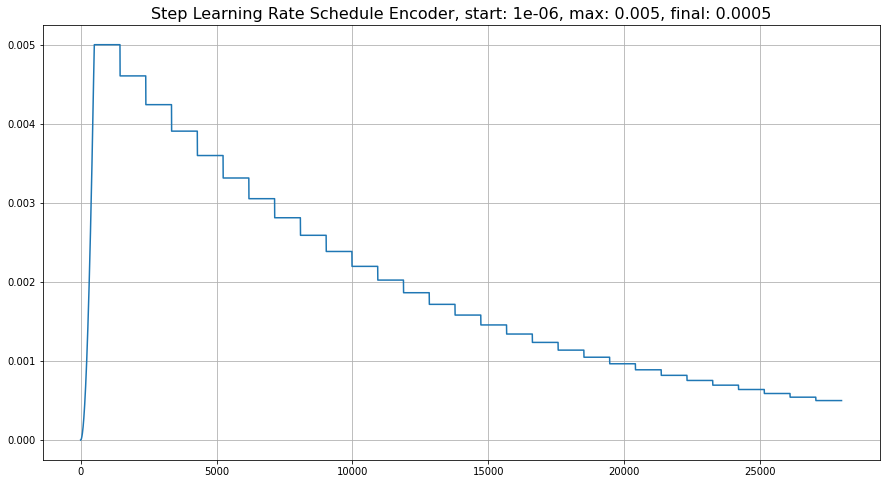

In [33]:
# plot the learning rate schedule
def plot_lr_schedule(lr_schedule, name):
    plt.figure(figsize=(15,8))
    plt.plot(lr_schedule)
    schedule_info = f'start: {lr_schedule[0]}, max: {max(lr_schedule)}, final: {lr_schedule[-1]}'
    plt.title(f'Step Learning Rate Schedule {name}, {schedule_info}', size=16)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, 1e-6, 5e-3, 5e-4 ,EPOCHS) for step in range(TOTAL_STEPS)]
plot_lr_schedule(LR_SCHEDULE, 'Encoder')

In [34]:
# converts a dense to a sparse tensor
# sparse tensors are required to compute the Levenshtein distance
def dense_to_sparse(dense):
    ones = tf.ones(dense.shape)
    indices = tf.where(ones)
    values = tf.gather_nd(dense, indices)
    sparse = tf.SparseTensor(indices, values, dense.shape)
    
    return sparse

# computes the levenshtein distance between the predictions and labels
def get_levenshtein_distance(preds, lbls):
    preds = tf.cast(preds, tf.int64)

    preds = tf.where(tf.not_equal(preds, START_TOKEN) & tf.not_equal(preds, END_TOKEN) & tf.not_equal(preds, PAD_TOKEN), preds, y=0)
    
    lbls = strategy.gather(lbls, axis=0)
    lbls = tf.cast(lbls, tf.int64)
    lbls = tf.where(tf.not_equal(lbls, START_TOKEN) & tf.not_equal(lbls, END_TOKEN) & tf.not_equal(lbls, PAD_TOKEN), lbls, y=0)
    
    preds_sparse = dense_to_sparse(preds)
    lbls_sparse = dense_to_sparse(lbls)

    batch_distance = tf.edit_distance(preds_sparse, lbls_sparse, normalize=False)
    mean_distance = tf.math.reduce_mean(batch_distance)
    
    return mean_distance

In [35]:
@tf.function()
def distributed_train_step(dataset):
    # Step function
    def train_step(inp, targ):
        total_loss = 0.0

        with tf.GradientTape() as tape:
            enc_output = encoder(inp, training=True)
            h, c = decoder.init_hidden_state(enc_output, training=True)
            dec_input = tf.expand_dims(targ[:, 0], 1)

            # Teacher forcing - feeding the target as the next input
            for idx in range(1, SEQ_LEN_OUT):
                t = targ[:, idx]
                t = tf.reshape(t, [BATCH_SIZE_BASE])
                # passing enc_output to the decoder
                predictions, h, c = decoder(dec_input, h, c, enc_output, training=True)

                # update loss and train metrics
                total_loss += loss_function(t, predictions)
                train_accuracy.update_state(t, predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(t, 1)

        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(total_loss, variables)
        gradients, _ = tf.clip_by_global_norm(gradients, 10.0)
        optimizer.apply_gradients(zip(gradients, variables))

        batch_loss = total_loss / (SEQ_LEN_OUT - 1)
        train_loss.update_state(batch_loss)
    
    # reset metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    # perform VERBOSE_FREQ train steps
    for _ in tf.range(tf.convert_to_tensor(VERBOSE_FREQ)):
        strategy.run(train_step, args=next(dataset))

In [36]:
def validation_step(inp, targ):
    total_loss = 0.0
    enc_output = encoder(inp, training=False)
    h, c = decoder.init_hidden_state(enc_output, training=False)
    dec_input = tf.expand_dims(targ[:, 0], 1)

    predictions_seq = tf.expand_dims(targ[:, 0], 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, SEQ_LEN_OUT):
        # passing enc_output to the decoder
        predictions, h, c = decoder(dec_input, h, c, enc_output, training=False)

        # add loss 
        # update loss and train metrics
        total_loss += loss_function(targ[:, t], predictions)
        
        # add predictions to pred_seq
        dec_input = tf.math.argmax(predictions, axis=1, output_type=tf.int32)
        dec_input = tf.expand_dims(dec_input, axis=1)
        dec_input = tf.cast(dec_input, LABEL_DTYPE)
        predictions_seq = tf.concat([predictions_seq, dec_input], axis=1)
        
    batch_loss = total_loss / (SEQ_LEN_OUT - 1)
    val_loss.update_state(batch_loss)
    
    return predictions_seq

In [37]:
@tf.function
def distributed_val_step(dataset):
    inp_val, targ_val = next(dataset)
    per_replica_predictions_seq = strategy.run(validation_step, args=(inp_val, targ_val))
    predictions_seq = strategy.gather(per_replica_predictions_seq, axis=0)
    
    return predictions_seq, targ_val

In [38]:
def get_val_metrics(val_dist_dataset):
    # reset metrics
    val_loss.reset_states()
    total_ls_distance = 0.0
    
    for step in range(VAL_STEPS):
        predictions_seq, targ = distributed_val_step(val_dist_dataset)
        levenshtein_distance = get_levenshtein_distance(predictions_seq, targ)
        total_ls_distance += levenshtein_distance
    
    return total_ls_distance / VAL_STEPS

In [39]:
def log(batch, t_start_batch, val_ls_distance=False):
    print(
        f'Step %s|' % f'{batch * VERBOSE_FREQ}/{TRAIN_STEPS}'.ljust(10, ' '),
        f'loss: %.3f,' % (train_loss.result() / VERBOSE_FREQ),
        f'acc: %.3f, ' % train_accuracy.result(),
    end='')
    
    if val_ls_distance:
        print(
            f'val_loss: %.3f, ' % (val_loss.result() / VERBOSE_FREQ),
            f'val lsd: %s,' % ('%.1f' % val_ls_distance).ljust(5, ' '),
        end='')
    # always end with batch duration and line break
    print(
        f'lr: %s,' % ('%.1E' % LRREDUCE.get_lr()).ljust(7),
        f't: %s sec' % int(time.time() - t_start_batch),
    )

In [40]:
class Stats():
    def __init__(self):
        self.stats = {
            'train_loss': [],
            'train_acc': [],
        }
        
    def update_stats(self):
        self.stats['train_loss'].append(train_loss.result() / VERBOSE_FREQ)
        self.stats['train_acc'].append(train_accuracy.result())
        
    def get_stats(self, metric):
        return self.stats[metric]
        
    def plot_stat(self, metric):
        plt.figure(figsize=(15,8))
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.plot(self.stats[metric])
        plt.grid()
        plt.title(f'{metric} stats', size=24)
        plt.show()
        
STATS = Stats()

In [41]:
# custom learning rate scheduler
class LRReduce():
    def __init__(self, optimizer, lr_schedule):
        self.opt = optimizer
        self.lr_schedule = lr_schedule
        # assign initial learning rate
        self.lr = lr_schedule[0]
        self.opt.learning_rate.assign(self.lr)
        
    def step(self, step):
        self.lr = self.lr_schedule[step]
        # assign learning rate to optimizer
        self.opt.learning_rate.assign(self.lr)
        
    def get_counter(self):
        return self.c
    
    def get_lr(self):
        return self.lr
        
LRREDUCE = LRReduce(optimizer, LR_SCHEDULE)

In [42]:
step_total = 0
for epoch in range(EPOCHS):
    print(f'***** EPOCH {epoch + 1} *****')
    
    t_start = time.time()
    t_start_batch = time.time()
    total_loss = 0
    
    # create distributed versions of dataset
    train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
    val_dist_dataset = iter(strategy.experimental_distribute_dataset(val_dataset))

    for step in range(1, STEPS_PER_EPOCH + 1):
        # train step
        distributed_train_step(train_dist_dataset)
        STATS.update_stats()
        
        # end of epoch validation
        if step == STEPS_PER_EPOCH:
            val_ls_distance = get_val_metrics(val_dist_dataset)
            # log with validation
            log(step, t_start_batch, val_ls_distance)
        else:
            # normal log
            log(step, t_start_batch)
            # reset start time batch
            t_start_batch = time.time()
            
        total_loss += train_loss.result()
        
        # learning rate step
        LRREDUCE.step(epoch * TRAIN_STEPS + step * VERBOSE_FREQ - 1)
        
        # stop training when NaN loss is detected, this can be caused by exploding gradients
        if np.isnan(total_loss):
            break
            
    # stop training when NaN loss is detected
    if np.isnan(total_loss):
        break

    print(f'Epoch {epoch} Loss {round(total_loss.numpy() / TRAIN_STEPS, 3)}, time: {int(time.time() - t_start)} sec\n')

***** EPOCH 1 *****
Step 100/1000  | loss: 3.696, acc: 0.047, lr: 1.0E-06, t: 440 sec
Step 200/1000  | loss: 1.557, acc: 0.566, lr: 2.0E-04, t: 96 sec
Step 300/1000  | loss: 0.822, acc: 0.707, lr: 7.9E-04, t: 96 sec
Step 400/1000  | loss: 0.640, acc: 0.758, lr: 1.8E-03, t: 96 sec
Step 500/1000  | loss: 0.537, acc: 0.795, lr: 3.2E-03, t: 96 sec
Step 600/1000  | loss: 0.447, acc: 0.828, lr: 5.0E-03, t: 96 sec
Step 700/1000  | loss: 0.369, acc: 0.858, lr: 5.0E-03, t: 96 sec
Step 800/1000  | loss: 0.328, acc: 0.873, lr: 5.0E-03, t: 96 sec
Step 900/1000  | loss: 0.301, acc: 0.883, lr: 5.0E-03, t: 96 sec
Step 1000/1000 | loss: 0.278, acc: 0.892, val_loss: 0.997,  val lsd: 66.4 ,lr: 5.0E-03, t: 152 sec
Epoch 0 Loss 0.897, time: 1366 sec

***** EPOCH 2 *****
Step 100/1000  | loss: 0.261, acc: 0.899, lr: 5.0E-03, t: 98 sec
Step 200/1000  | loss: 0.243, acc: 0.906, lr: 5.0E-03, t: 96 sec
Step 300/1000  | loss: 0.230, acc: 0.911, lr: 5.0E-03, t: 96 sec
Step 400/1000  | loss: 0.218, acc: 0.915, lr

In [43]:
# save weights
encoder.save_weights('/content/drive/MyDrive/Kaggle/encoder.h5')
decoder.save_weights('/content/drive/MyDrive/Kaggle/decoder.h5')

OSError: Unable to create file (unable to open file: name = '/content/drive/MyDrive/Kaggle/encoder.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

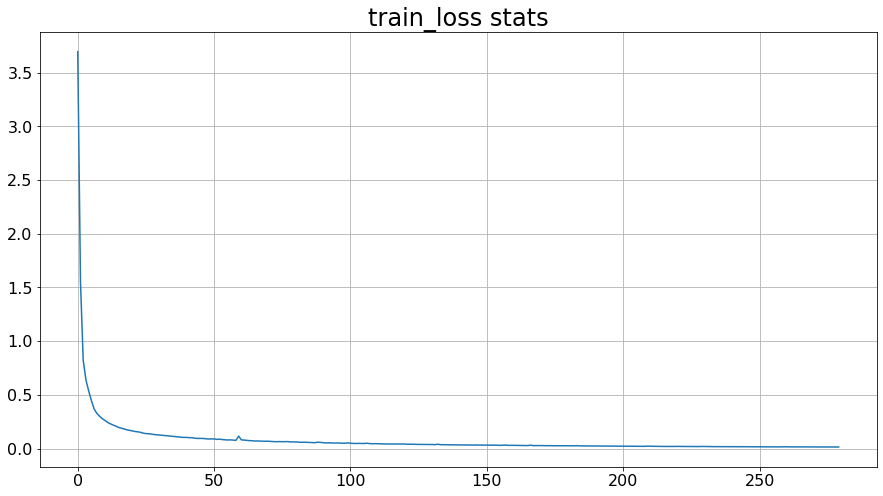

In [44]:
STATS.plot_stat('train_loss')

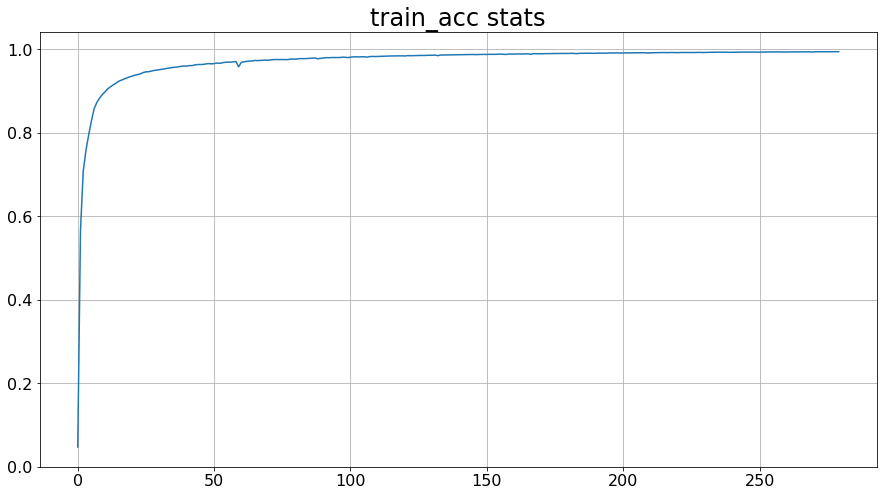

In [45]:
STATS.plot_stat('train_acc')

In [46]:
# convert the integer encoded predictions to a string
def int2char(i_str):
    res = ''
    for i in i_str.numpy():
        c = int_to_vocabulary.get(i)
        if c not in ['<start>', '<end>', '<pad>']:
            res += c
    return res

  0%|          | 0/200 [00:00<?, ?it/s]

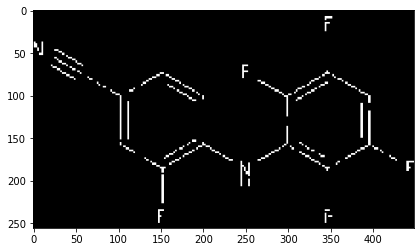

predicted: 	D,,cOm/,9,nS,46Ol6OO6O76O4676O2BO7PO86,8B,7P,2BOlP,l6,O6l6OsB,tPO,6,sB,mbOtP,,6t6Om646O6,6s628B,OP,2BO4P,l6,,nrO6,bm6O,b,l628cb2c,
actual: 	DO2c4/49,nSOm67626sB46OlPO6,6O8B7P,86O26OOBO7PtBO4Pm6lBOsPO,BO2POtnrO6mb,8c


  0%|          | 0/200 [00:00<?, ?it/s]

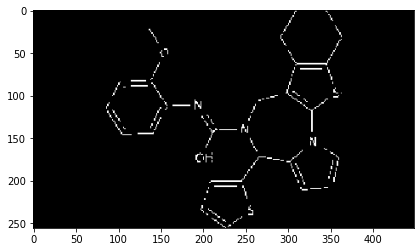

predicted: 	D2Oc289m(,1,nSO62t6,s6O,64626t6,8B,sP,lB27P2m62OB2tP2s6Ot6,,6,O6l6m6s6O462,B,Obm86,t6Om676O76m86,tP,76,46OO6,6O86,m6,2B2OPO26Os628B24P2lB,mP,snr2b4b7blbOO6O7b,,b28cb,bmbsbtbO8bOt6Olc,bOc2bBcb2mb27P
actual: 	D,sc,492(,1,nSO62O6,O6OO6m626l6OlB,OP,76,sB28P,l6Os6Ot6O76t6,646O,6,,BO7P226,4BOtP,t6Om6s6O86,8B,tP,mB,lP,26O2676O462,6,2nr26mbs67bl6OObO26O4b,mcb,b4btbO,bOsc,bOc2bBcb,7b28P


  0%|          | 0/200 [00:00<?, ?it/s]

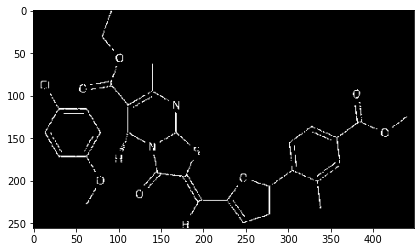

predicted: 	D2mc28D592(71nSO676m462mBm,P,l6OtB,P2762462tB2OB,lP,s6Os6,8B2l62Pt6OO6,4B,sP2sP22Bm8P,t6O46,,6l6O,6,7Bms6,mP,O6O86O26,2B2,BmOPmm6sPOlBmP,tB,OP28B,,Pm76O7B4Pm8nrt6Osb2,cb7bO7c,bO6sc2n+,l6Os6n02,6b246nH
actual: 	D2Oc,7D59,(71nSO6s6m8628B27P,s6O7B2P2262O62mB,7B,sP,,6Om6OlB2,Pt6OO6,2B,,P2t6mP,tB24P,4Bm,62OPO46,86l6O,6,mBmO6,8P,O6O8676OtBO26OsB,OP,P,lB2sP2l64nr76O4b,7cbsc,bO64c2n+,46O46n0,76nH8nhO


In [47]:
def evaluate(img, actual=None):
    # get encoder output and initiate LSTM hidden and carry state
    enc_out = encoder(tf.expand_dims(img, axis=0), training=False)
    h, c = decoder.init_hidden_state(enc_out, training=False)
    
    # the "<start>" token is used as first character when predicting
    dec_input = tf.expand_dims([vocabulary_to_int.get('<start>')], 0)
    result = ''
    
    for t in tqdm(range(SEQ_LEN_OUT)):
        predictions, h, c = decoder(dec_input, h, c, enc_out, training=False)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_char = int_to_vocabulary.get(predicted_id)

        # stop predicting when "<end>" token is predicted
        if predicted_char == '<end>':
            break
        
        # add every character except "<start>"
        if result != '<start>':
            result += predicted_char

        # predicted charachter is used as input to the decoder to predict the next character
        dec_input = tf.expand_dims([predicted_id], 0)
    
    # plot the molecule image
    plt.figure(figsize=(7, 4))
    plt.imshow(img.numpy().astype(np.float32))
    plt.show()
    print(f'predicted: \t{result}')
    print(f'actual: \t{int2char(actual)}')

for n in range(3):
    evaluate(val_imgs[n], actual=val_lbls[n])